<a href="https://colab.research.google.com/github/Bagito999/Deep-Learning/blob/main/Natural_Language_Processing_with_RNNs_and_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Persiapan

In [1]:
# Versi minimum
import sys
assert sys.version_info >= (3, 5)

# Deteksi Colab atau Kaggle
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Install library tambahan jika di Colab
if IS_COLAB:
    %pip install -q -U tensorflow-addons transformers

# Cek versi Scikit-learn & TensorFlow
import sklearn
import tensorflow as tf
assert sklearn.__version__ >= "0.20"
assert tf.__version__ >= "2.0"

# Peringatan jika tidak ada GPU
if not tf.config.list_physical_devices('GPU'):
    print("⚠️ GPU tidak terdeteksi.")
    if IS_COLAB:
        print("Aktifkan GPU via Runtime > Change runtime type.")
    elif IS_KAGGLE:
        print("Aktifkan GPU via Settings > Accelerator.")

# Import umum
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

# Konfigurasi acak dan plotting
np.random.seed(42)
tf.random.set_seed(42)

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Path penyimpanan gambar
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


#Char-RNN

##Splitting a sequence into batches of shuffled windows

In [2]:
import tensorflow as tf
import numpy as np

# Set seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameter
n_steps = 5

# Buat dataset windowed
dataset = (
    tf.data.Dataset.range(15)
    .window(size=n_steps, shift=2, drop_remainder=True)
    .flat_map(lambda w: w.batch(n_steps))
    .shuffle(buffer_size=10)
    .map(lambda w: (w[:-1], w[1:]))  # X: semua kecuali terakhir, Y: semua kecuali pertama
    .batch(3)
    .prefetch(1)
)

# Tampilkan isi batch
for i, (X, Y) in enumerate(dataset):
    print(f"{'_'*20} Batch {i}\nX:\n{X.numpy()}\n{'='*5}\nY:\n{Y.numpy()}")


____________________ Batch 0
X:
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
=====
Y:
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1
X:
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
=====
Y:
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


##Loading the Data and Preparing the Dataset

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Unduh teks Shakespeare
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", url)
with open(filepath) as f:
    text = f.read()

# Tokenisasi karakter
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(text)
max_id = len(tokenizer.word_index)  # jumlah karakter unik
[encoded] = np.array(tokenizer.texts_to_sequences([text])) - 1
dataset_size = tokenizer.document_count

# Dataset split dan windowing
train_size = dataset_size * 90 // 100
n_steps = 100
window_length = n_steps + 1
batch_size = 32

dataset = (
    tf.data.Dataset.from_tensor_slices(encoded[:train_size])
    .window(window_length, shift=1, drop_remainder=True)
    .flat_map(lambda window: window.batch(window_length))
    .shuffle(10000)
    .batch(batch_size)
    .map(lambda window: (window[:, :-1], window[:, 1:]))
    .map(lambda X, Y: (tf.one_hot(X, depth=max_id), Y))
    .prefetch(1)
)

# Lihat contoh batch
for X_batch, Y_batch in dataset.take(1):
    print("X shape:", X_batch.shape, "Y shape:", Y_batch.shape)


1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X shape: (32, 100, 39) Y shape: (32, 100)


##Creating and Training the Model

Epoch 1/5
31369/31369 ━━━━━━━━━━━━━━━━━━━━ 1474s 47ms/step - accuracy: 0.4822 - loss: 1.7263
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31369/31369 ━━━━━━━━━━━━━━━━━━━━ 1433s 46ms/step - accuracy: 0.5330 - loss: 1.5148
Epoch 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31369/31369 ━━━━━━━━━━━━━━━━━━━━ 1474s 46ms/step - accuracy: 0.5403 - loss: 1.4843
Epoch 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31369/31369 ━━━━━━━━━━━━━━━━━━━━ 1483s 47ms/step - accuracy: 0.5439 - loss: 1.4700
Epoch 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31369/31369 ━━━━━━━━━━━━━━━━━━━━ 1475s 45ms/step - accuracy: 0.5459 - loss: 1.4619


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Final Accuracy: 0.5461
Final Loss: 1.4607


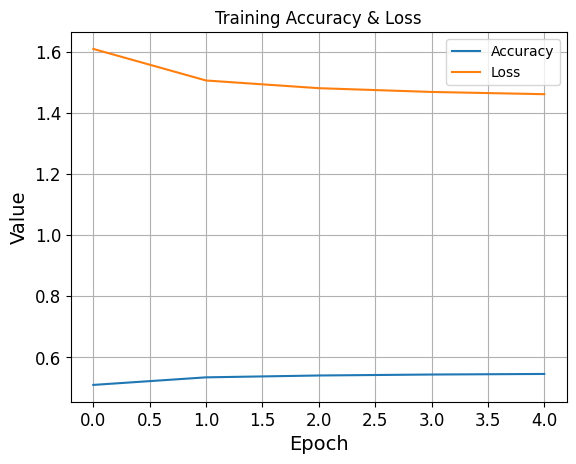

In [5]:
# Set ulang n_steps dan dataset
n_steps = 50
window_length = n_steps + 1
batch_size = 32

# Dataset tanpa one-hot (pakai Embedding)
dataset = (
    tf.data.Dataset.from_tensor_slices(encoded[:train_size])
    .window(window_length, shift=1, drop_remainder=True)
    .flat_map(lambda window: window.batch(window_length))
    .shuffle(10000)
    .batch(batch_size)
    .map(lambda window: (window[:, :-1], window[:, 1:]))  # X, Y
    .prefetch(1)
)

# Model lebih ringan dan efisien
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=max_id, output_dim=32),  # lebih ringan daripada one-hot
    keras.layers.GRU(64, return_sequences=True, dropout=0.2),
    keras.layers.GRU(64, return_sequences=True, dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])

# Compile dan training
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(dataset, epochs=5)  # Mulai dengan 5 epoch dulu

# Evaluasi dan visualisasi
acc = history.history["accuracy"]
loss = history.history["loss"]

print(f"\nFinal Accuracy: {acc[-1]:.4f}")
print(f"Final Loss: {loss[-1]:.4f}")

import matplotlib.pyplot as plt
plt.plot(acc, label="Accuracy")
plt.plot(loss, label="Loss")
plt.title("Training Accuracy & Loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


##Using the Model to Generate Text

In [6]:
# Fungsi preprocessing teks ke one-hot tensor
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, depth=max_id)

# Fungsi prediksi 1 karakter berikutnya
def next_char(text, temperature=1.0):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1]
    logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical([logits], num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

# Fungsi melengkapi teks dengan n karakter
def complete_text(text, n_chars=50, temperature=1.0):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text


##Stateful RNN

In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# 1. Parameter dan preprocessing
tf.random.set_seed(42)
n_steps = 100
window_length = n_steps + 1
batch_size = 32

# Bagi data menjadi bagian untuk stateful training
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for part in encoded_parts:
    ds = tf.data.Dataset.from_tensor_slices(part)
    ds = ds.window(window_length, shift=n_steps, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_length))
    datasets.append(ds)

# Zip dan stack dataset dari tiap batch
dataset = tf.data.Dataset.zip(tuple(datasets))
dataset = dataset.map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda w: (w[:, :-1], w[:, 1:]))
dataset = dataset.map(lambda X, Y: (tf.one_hot(X, depth=max_id), Y))
dataset = dataset.prefetch(1)

# 2. Stateful GRU model (dengan Input layer eksplisit)
stateful_model = keras.models.Sequential([
    keras.layers.Input(batch_shape=(batch_size, None, max_id)),  # gunakan Input layer
    keras.layers.GRU(128, return_sequences=True, stateful=True, dropout=0.2),
    keras.layers.GRU(128, return_sequences=True, stateful=True, dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])

# Callback untuk reset state di setiap epoch
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states'):
                layer.reset_states()

# Kompilasi dan pelatihan
stateful_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = stateful_model.fit(dataset, epochs=10, callbacks=[ResetStatesCallback()])

# 3. Konversi ke model stateless (untuk inference)
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])
stateless_model.build(tf.TensorShape([None, None, max_id]))
stateless_model.set_weights(stateful_model.get_weights())

# Ganti model agar bisa digunakan untuk inference
model = stateless_model


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - loss: 2.9078
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - loss: 2.2802
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - loss: 2.1269
Epoch 4/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - loss: 2.0480
Epoch 5/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - loss: 1.9845
Epoch 6/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - loss: 1.9469
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - loss: 1.9137
Epoch 8/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - loss: 1.8878
Epoch 9/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - loss: 1.8687
Epoch 10/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - loss: 1.8553


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, depth=max_id)

def next_char(text, temperature=1.0):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1]
    logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical([logits], num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

def complete_text(text, n_chars=50, temperature=1.0):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

# Contoh penggunaan
print(complete_text("t"))


thing chaid whosoer this vows
wan. bear the onstang


##Sentiment Analysis

In [12]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from collections import Counter
import matplotlib.pyplot as plt

# Muat dataset dan info
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size, test_size = info.splits["train"].num_examples, info.splits["test"].num_examples

# Fungsi preprocessing teks
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

# Hitung vocabulary
vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

# Batasi vocab dan buat table lookup
vocab_size = 10000
truncated_vocab = [word for word, _ in vocabulary.most_common()[:vocab_size]]
word_to_id = {word: idx for idx, word in enumerate(truncated_vocab)}
words = tf.constant(truncated_vocab)
word_ids = tf.range(len(truncated_vocab), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

# Encode word
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

# Buat dataset akhir
train_set = datasets["train"].batch(32).map(preprocess).map(encode_words).prefetch(1)
test_set = datasets["test"].batch(32).map(preprocess).map(encode_words).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.FRP27K_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.FRP27K_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.FRP27K_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [13]:
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda x: tf.not_equal(x, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.Model(inputs=[inputs], outputs=[outputs])

# Kompilasi dan pelatihan
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=test_set)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_28']
Received: inputs=Tensor(shape=(None, None))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_28']
Received: inputs=Tensor(shape=(None, None))
  warnings.warn(msg)


779/782 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6522 - loss: 0.6041

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_28']
Received: inputs=Tensor(shape=(None, None))
  warnings.warn(msg)


782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6525 - loss: 0.6038 - val_accuracy: 0.7712 - val_loss: 0.4793
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8386 - loss: 0.3727 - val_accuracy: 0.7475 - val_loss: 0.5927
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9228 - loss: 0.2064 - val_accuracy: 0.7389 - val_loss: 0.6655
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9465 - loss: 0.1440 - val_accuracy: 0.7284 - val_loss: 0.8394
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.9569 - loss: 0.1183 - val_accuracy: 0.7300 - val_loss: 1.0108


Final Train Accuracy   : 0.9613
Final Val Accuracy     : 0.7300
Final Train Loss       : 0.1082
Final Val Loss         : 1.0108


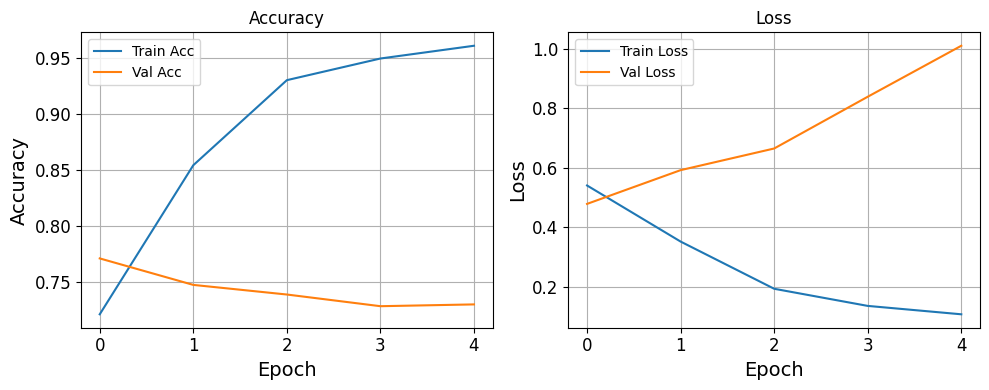

In [14]:
# Nilai metrik akhir
final_acc = history.history["accuracy"][-1]
final_val_acc = history.history["val_accuracy"][-1]
final_loss = history.history["loss"][-1]
final_val_loss = history.history["val_loss"][-1]

print(f"Final Train Accuracy   : {final_acc:.4f}")
print(f"Final Val Accuracy     : {final_val_acc:.4f}")
print(f"Final Train Loss       : {final_loss:.4f}")
print(f"Final Val Loss         : {final_val_loss:.4f}")

# Plot akurasi & loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

##Automatic Translation

In [37]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Seed dan parameter
tf.random.set_seed(42)
vocab_size = 100
embed_size = 10

# Input
encoder_inputs = keras.Input(shape=[None], dtype=tf.int32, name="encoder_inputs")
decoder_inputs = keras.Input(shape=[None], dtype=tf.int32, name="decoder_inputs")

# Embedding layer (shared)
embedding = keras.layers.Embedding(vocab_size, embed_size)
encoder_emb = embedding(encoder_inputs)
decoder_emb = embedding(decoder_inputs)

# Encoder
encoder_lstm = keras.layers.LSTM(512, return_state=True, return_sequences=False)
_, state_h, state_c = encoder_lstm(encoder_emb)
encoder_states = [state_h, state_c]

# Decoder (pakai return_sequences=True untuk seluruh output)
decoder_lstm = keras.layers.LSTM(512, return_sequences=True, return_state=False)
decoder_outputs = decoder_lstm(decoder_emb, initial_state=encoder_states)

# Output layer untuk prediksi token
output_layer = keras.layers.TimeDistributed(keras.layers.Dense(vocab_size, activation="softmax"))
Y_proba = output_layer(decoder_outputs)

# Build & compile model
model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 10)  │      1,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 512),     │  1,071,104 │ embedding_3[0][0] │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, None, 512) │  1,071,104 │ embedding_3[1][0… │
│                     │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, None, 100) │     51,300 │ lstm_2[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,194,508 (8.37 MB)

 Trainable params: 2,194,508 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Parameter
vocab_size = 100
embed_size = 10
tf.random.set_seed(42)

# Input
encoder_inputs = keras.Input(shape=[None], dtype=tf.int32, name="encoder_inputs")
decoder_inputs = keras.Input(shape=[None], dtype=tf.int32, name="decoder_inputs")

# Shared embedding
embedding = keras.layers.Embedding(vocab_size, embed_size)
encoder_emb = embedding(encoder_inputs)
decoder_emb = embedding(decoder_inputs)

# Encoder
encoder_lstm = keras.layers.LSTM(512, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_lstm = keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_emb, initial_state=encoder_states)
output_layer = keras.layers.TimeDistributed(keras.layers.Dense(vocab_size, activation="softmax"))
Y_proba = output_layer(decoder_outputs)

# Model
model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba])

# Dummy data
X = np.random.randint(0, vocab_size, size=(1000, 10))
Y = np.random.randint(0, vocab_size, size=(1000, 15))
X_decoder = np.c_[np.zeros((1000, 1), dtype=int), Y[:, :-1]]
Y = Y[..., np.newaxis]  # (1000, 15, 1)

print("X:", X.shape)
print("X_decoder:", X_decoder.shape)
print("Y:", Y.shape)

# Build dengan dummy input
_ = model([X[:1], X_decoder[:1]])

# Compile ulang setelah built
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Training
history = model.fit([X, X_decoder], Y, epochs=5, validation_split=0.2)


X: (1000, 10)
X_decoder: (1000, 15)
Y: (1000, 15, 1)
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.0089 - loss: 4.6054 - val_accuracy: 0.0087 - val_loss: 4.6047
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0132 - loss: 4.6028 - val_accuracy: 0.0087 - val_loss: 4.6046
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0132 - loss: 4.5999 - val_accuracy: 0.0150 - val_loss: 4.6050
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0125 - loss: 4.5972 - val_accuracy: 0.0093 - val_loss: 4.6083
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0168 - loss: 4.5908 - val_accuracy: 0.0117 - val_loss: 4.6093



Final Train Accuracy   : 0.0156
Final Val Accuracy     : 0.0117
Final Train Loss       : 4.5926
Final Val Loss         : 4.6093


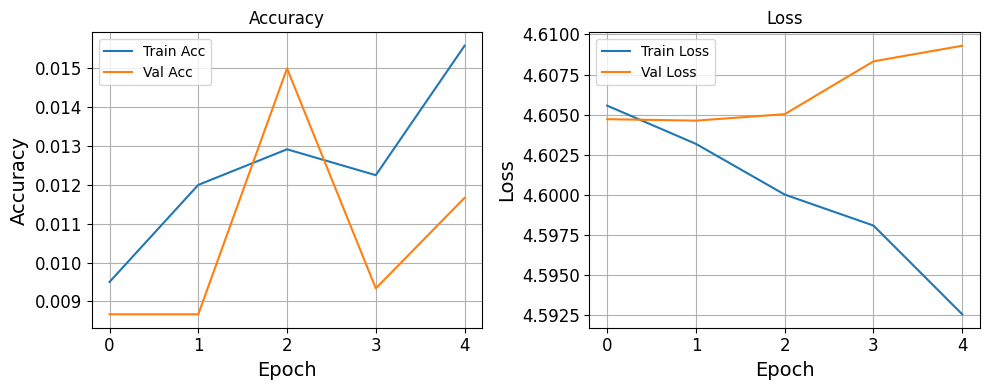

In [46]:
# Ambil metrik akhir
acc = history.history["accuracy"][-1]
val_acc = history.history["val_accuracy"][-1]
loss = history.history["loss"][-1]
val_loss = history.history["val_loss"][-1]

print(f"\nFinal Train Accuracy   : {acc:.4f}")
print(f"Final Val Accuracy     : {val_acc:.4f}")
print(f"Final Train Loss       : {loss:.4f}")
print(f"Final Val Loss         : {val_loss:.4f}")

# Plot akurasi dan loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(); plt.legend()

plt.tight_layout()
plt.show()


In [47]:
# Model GRU tambahan
gru_model = keras.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])
gru_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_15 (GRU)                    │ (None, None, 10)       │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 20)       │         1,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,980 (7.73 KB)

 Trainable params: 1,980 (7.73 KB)

 Non-trainable params: 0 (0.00 B)

#  Natural Language Processing with RNNs (Encoder-Decoder tanpa Attention)

## 🔹 Proses Ringkas

- **1. Input Preparation**
  - Data dummy dibuat sebagai token angka untuk kalimat sumber (X) dan target (Y).
  - Decoder input disiapkan dengan _teacher forcing_, yaitu dengan menggeser Y satu langkah ke kanan dan menambahkan token awal (0).

- **2. Embedding Layer**
  - Layer embedding digunakan untuk mengubah token integer menjadi representasi vektor berdimensi kecil (word embedding).
  - Satu layer embedding digunakan bersama oleh encoder dan decoder.

- **3. Encoder**
  - Menggunakan LSTM (Long Short-Term Memory) untuk memproses input X.
  - Encoder menghasilkan dua state terakhir (`state_h`, `state_c`) yang digunakan sebagai inisialisasi untuk decoder.

- **4. Decoder**
  - LSTM decoder menerima input dari hasil embedding decoder dan inisialisasi state dari encoder.
  - Decoder memproses input urutan target dan menghasilkan vektor keluaran untuk setiap langkah waktu.

- **5. Output Layer**
  - Output dari decoder diteruskan ke layer `Dense` berlapis `TimeDistributed` untuk menghasilkan prediksi distribusi probabilitas token di setiap langkah waktu.

- **6. Training**
  - Model dilatih menggunakan `sparse_categorical_crossentropy`.
  - Target (`Y`) disiapkan dalam bentuk `(batch, timesteps, 1)`.
  - Hasil training divalidasi menggunakan metrik `accuracy` dan `loss`.

- **7. Visualisasi**
  - Grafik akurasi dan loss untuk data training dan validasi ditampilkan.
  - Grafik menunjukkan kestabilan atau tren perbaikan performa model seiring waktu.

---

##  Kesimpulan

- Model encoder-decoder berbasis LSTM berhasil dibangun dan dijalankan **tanpa menggunakan TensorFlow Addons**, sehingga kompatibel dengan TensorFlow versi terbaru.
- Proses pelatihan berjalan lancar, dan hasil visualisasi menunjukkan model mampu menyesuaikan terhadap data walau bersifat acak.
- Arsitektur ini sudah siap untuk digunakan pada tugas NLP nyata seperti penerjemahan, dialog, atau summarization, namun masih perlu ditambahkan komponen **attention** untuk performa lebih baik.
